# <font color=red>Tutorial 10 - Classification - Cross Validation and Pre-Processing </font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('tableau-colorblind10')
sns.set_palette("viridis")

## K-fold Cross-validation

The train-test-split method we used in the last tutorial for evaluating our model is dependent on how the data is split into train and test sets. <br>
The cross-validation method is used to overcome this problem.<br>
The K-fold cross-validation method works as follows:
* Randomly split the training set into k groups (folds).
* One of the groups is used as a validation set (blue) and the rest (red) are used as a training set.
* The process is repeated until each group was used as a validation set.

<img src="cross-validation.png" width=750 height=750>

Lets try the K-fold cross validation method using 5 folds (K=5) on our model from the last tutorial

### Loading iris data

In [2]:
from sklearn import datasets

iris_data = datasets.load_iris()
X = iris_data.data
Y = iris_data.target

### Using cross-validation for evaluation

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# split to train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

# Create a new kNN model
knn_cv = KNeighborsClassifier(n_neighbors=5)

# Train model using the cross-validation method using 5 groups (cv=5)
cv_scores = cross_val_score(knn_cv, X_train, Y_train, cv=5) # (model, features, labels, k)
cv_scores

array([1.        , 0.95833333, 0.95833333, 0.91666667, 0.95833333])

In [4]:
print('Mean : ' + str(np.mean(cv_scores)) + ', STD: ' + str(np.std(cv_scores)))

Mean : 0.9583333333333334, STD: 0.026352313834736508


## **Case Study - Titanic**

In the following classification task, we will use Titanic data from Seaborn. We will try to build a KNN model that predicts if a passenger survived based on the provided features.

In [5]:
original_df = sns.load_dataset("titanic")
original_df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


We will use a subset of the original data:

In [6]:
df = original_df.iloc[:,:9].drop(columns='pclass')
df.head()

,survived,sex,age,sibsp,parch,fare,embarked,class
0,0,male,22.0,1,0,7.2500,S,Third
1,1,female,38.0,1,0,71.2833,C,First
2,1,female,26.0,0,0,7.9250,S,Third
3,1,female,35.0,1,0,53.1000,S,First
4,0,male,35.0,0,0,8.0500,S,Third


* **sibsp** - Number of siblings / spouses aboard the Titanic
* **parch** - Number of parents / children aboard the Titanic
* **fare** - Passenger fare
* **embarked** - Port of embarkation: C = Cherbourg, Q = Queenstown,S = Southampton
* **class** - A proxy for socio-economic status (SES)
    * First = Upper
    * Second = Middle
    * Third = Lower

In [7]:
df.shape

(891, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  891 non-null    int64   
 1   sex       891 non-null    object  
 2   age       714 non-null    float64 
 3   sibsp     891 non-null    int64   
 4   parch     891 non-null    int64   
 5   fare      891 non-null    float64 
 6   embarked  889 non-null    object  
 7   class     891 non-null    category
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 49.9+ KB


There are some missing values, it is critical to remove them since our model will not be able to deal with missing data (cannot calculate distance from NaN)

In [9]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   survived  712 non-null    int64   
 1   sex       712 non-null    object  
 2   age       712 non-null    float64 
 3   sibsp     712 non-null    int64   
 4   parch     712 non-null    int64   
 5   fare      712 non-null    float64 
 6   embarked  712 non-null    object  
 7   class     712 non-null    category
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 45.3+ KB


In [10]:
df.head()

,survived,sex,age,sibsp,parch,fare,embarked,class
0,0,male,22.0,1,0,7.2500,S,Third
1,1,female,38.0,1,0,71.2833,C,First
2,1,female,26.0,0,0,7.9250,S,Third
3,1,female,35.0,1,0,53.1000,S,First
4,0,male,35.0,0,0,8.0500,S,Third


### Pre-Processing

For our kNN model to perform better it is critical to pre-process the data. Pre-processing includes the following steps:
1. Set non-numerical (categorical) data ready for kNN model - our kNN model does not know how to handle strings (it does not know the distance between 'male' and 'female'). Therefore, we will have to convert categorical features to a numeric scale.
2. Since kNN is based on a distance metric, it is important to use a scaling method on the features, so that each feature will have a similar impact on the model.

#### 1. Convert categorical features to a numeric scale

There are two main types of categorical features:
1. **Nominal Categories** - Nominal categories are unordered e.g. colours, gender, nationality.
2. **Ordinal Categories** - Ordinal categories are ordered, e.g. school grades, price ranges, salary bands.

In [11]:
df.head()

,survived,sex,age,sibsp,parch,fare,embarked,class
0,0,male,22.0,1,0,7.2500,S,Third
1,1,female,38.0,1,0,71.2833,C,First
2,1,female,26.0,0,0,7.9250,S,Third
3,1,female,35.0,1,0,53.1000,S,First
4,0,male,35.0,0,0,8.0500,S,Third


We have three categorical features: 'sex', 'embarked' and 'class'. 'sex' and 'embarked' are nominal categorical features (unordered), while the 'class' feature is ordinal (First > Second > Third). We will use `pandas.get_dummies()` on nominal categorical features, and `pandas.replace()` for ordinal categorical features.

`pandas.get_dummies()` method takes categorical feature as an argument. Then it creates a dummy variable for every label in the feature, such that each dummy variable holds data as 1 or 0. 1 indicates the presence of a particular label and 0 indicates the absence of a particular label. We will use it to encode the nominal categorical features  - 'sex' and 'embarked'.

In [12]:
df['sex'].value_counts()

male      453
female    259
Name: sex, dtype: int64

In [13]:
df['embarked'].value_counts()

S    554
C    130
Q     28
Name: embarked, dtype: int64

In [14]:
encoded_df = pd.get_dummies(df, columns=['sex', 'embarked'], drop_first=True)
encoded_df.sample(10)

,survived,age,sibsp,parch,fare,class,sex_male,embarked_Q,embarked_S
744,1,31.00,0,0,7.9250,Third,1,0,1
637,0,31.00,1,1,26.2500,Second,1,0,1
314,0,43.00,1,1,26.2500,Second,1,0,1
702,0,18.00,0,1,14.4542,Third,0,0,0
171,0,4.00,4,1,29.1250,Third,1,1,0
570,1,62.00,0,0,10.5000,Second,1,0,1
62,0,45.00,1,0,83.4750,First,1,0,1
278,0,7.00,4,1,29.1250,Third,1,1,0
165,1,9.00,0,2,20.5250,Third,1,0,1
644,1,0.75,2,1,19.2583,Third,0,0,0


In the above code, we passed an argument `drop_first=True`, this indicates it drops one dummy variable from all the dummy variables created for a feature.

To handle the ordinal categorical feature ('class'), we will use `pandas.replace()` to find and replace the value for each label in the feature, in order to satisfy the intrinsic ordering among them.

In [15]:
encoded_df['class'].value_counts()

Third     355
First     184
Second    173
Name: class, dtype: int64

In [16]:
encoded_df.replace({'class': {'Third': 1, 'Second': 2, 'First': 3}}, inplace=True)
encoded_df["class"] = encoded_df["class"].astype(int)
encoded_df.sample(10)

,survived,age,sibsp,parch,fare,class,sex_male,embarked_Q,embarked_S
67,0,19.0,0,0,8.1583,1,1,0,1
321,0,27.0,0,0,7.8958,1,1,0,1
627,1,21.0,0,0,77.9583,3,0,0,1
219,0,30.0,0,0,10.5000,2,1,0,1
54,0,65.0,0,1,61.9792,3,1,0,0
318,1,31.0,0,2,164.8667,3,0,0,1
402,0,21.0,1,0,9.8250,1,0,0,1
23,1,28.0,0,0,35.5000,3,1,0,1
437,1,24.0,2,3,18.7500,2,0,0,1
750,1,4.0,1,1,23.0000,2,0,0,1


#### 2. Scaling features

Min-max scaling is a common feature pre-processing technique which results in scaled data values that fall in the range [0,1]:

$\dfrac{x_i - min(X)}{max(X) - min(X)}$

The right way to test our model is to fit our scaler based on the features on the training set, and then apply this scaling (in our case - find the min and max) to the test set. We should provide a model that is trained only on the training set.

In [17]:
X = encoded_df.iloc[:, 1:]  # features
Y = encoded_df.iloc[:, 0]  # labels
print(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

0      0
1      1
2      1
3      1
4      0
      ..
885    0
886    0
887    1
889    1
890    0
Name: survived, Length: 712, dtype: int64


In [18]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

Notice that we use only transform without fit for the test set, since we want our scaler to be fitted (setting the min and max) only according to the training set.

We will use these scaled features soon in the exercise section for running our KNN model.

#### Feature selection

Not all features are good predictors for a given classification problem. We would like to use the features that are useful for distinguishing between the classes, because if we include features that aren't we might add noise to our classifier.

One simple way to find useful features is examining the correlation of features with our target variable (the class). Features that correlate strongly with the class, whether negatively or positively, can help distinguish between the classes.

We can visualize correlations using a heatmap.

In [19]:
encoded_df.corr()

,survived,age,sibsp,parch,fare,class,sex_male,embarked_Q,embarked_S
survived,1.000000,-0.082446,-0.015523,0.095265,0.266100,0.356462,-0.536762,-0.048966,-0.159015
age,-0.082446,1.000000,-0.307351,-0.187896,0.093143,0.365902,0.099037,-0.021693,-0.025431
sibsp,-0.015523,-0.307351,1.000000,0.383338,0.139860,-0.065187,-0.106296,0.051331,0.018968
parch,0.095265,-0.187896,0.383338,1.000000,0.206624,-0.023666,-0.249543,-0.009417,0.013259
fare,0.266100,0.093143,0.139860,0.206624,1.000000,0.552893,-0.182457,-0.062346,-0.250994
class,0.356462,0.365902,-0.065187,-0.023666,0.552893,1.000000,-0.150826,-0.131989,-0.197831
sex_male,-0.536762,0.099037,-0.106296,-0.249543,-0.182457,-0.150826,1.000000,-0.027256,0.109078
embarked_Q,-0.048966,-0.021693,0.051331,-0.009417,-0.062346,-0.131989,-0.027256,1.000000,-0.378859
embarked_S,-0.159015,-0.025431,0.018968,0.013259,-0.250994,-0.197831,0.109078,-0.378859,1.000000


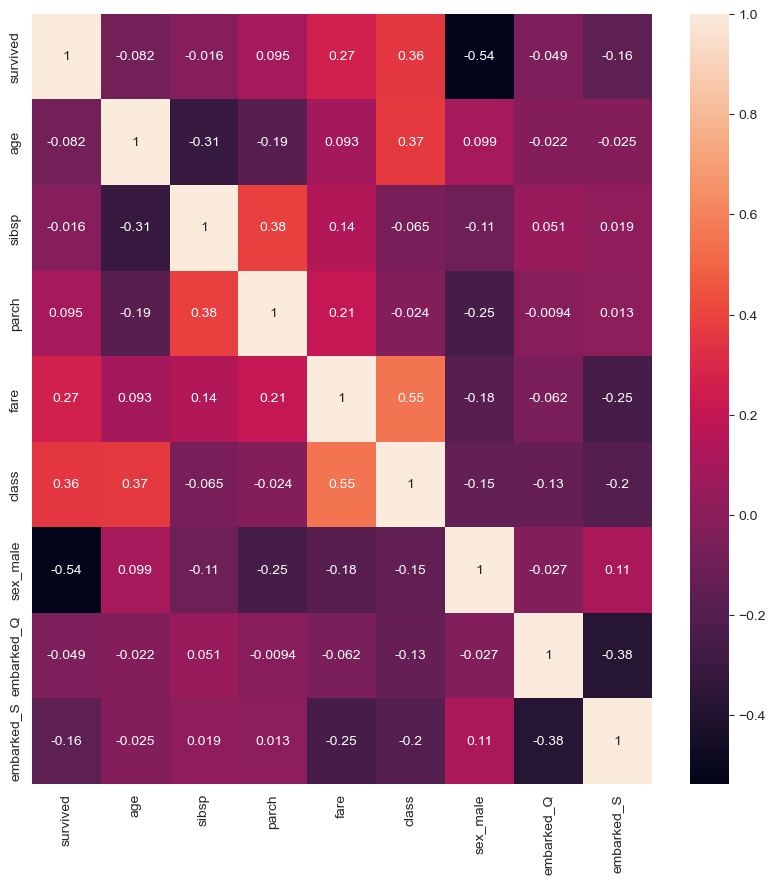

In [20]:
# compute correlation between each pair of variables in data frame
correlations = encoded_df.corr()

# plot heat map
plt.figure(figsize=(10,10))
g=sns.heatmap(correlations,annot=True)

In [21]:
correlations.reindex(correlations["survived"].abs().sort_values().index)["survived"] # ordered by absolute value

sibsp        -0.015523
embarked_Q   -0.048966
age          -0.082446
parch         0.095265
embarked_S   -0.159015
fare          0.266100
class         0.356462
sex_male     -0.536762
survived      1.000000
Name: survived, dtype: float64

## <font color=blue>**Exercise**</font>

Now that we have a processed data we are ready to run our model:

1. Run a kNN model to predict if a passenger survived. Use the k-fold cross validation (K=5) method to pick the optimal K.
2. Use the optimal K to train and test your model (train on the entire training set). What is accuracy of the model on test set?
3. Did the normalization improve the model? compare the model performance after and before normalization.
4. Does feature selection improve the model? choose the top 3 features that correlate with the label.

In [22]:
# Write yor code here


## <font color=blue>**Solution**</font>

In [23]:
# 1
k_avg_score = np.zeros(21)
for k in range(1, 21):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model, scaled_X_train, Y_train, cv=5)
    k_avg_score[k] = cv_scores.mean()

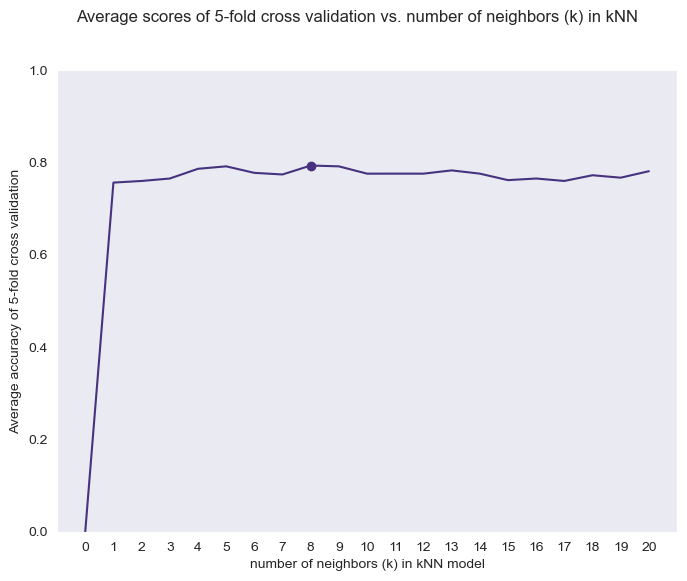

In [24]:
fig, ax = plt.subplots()
ax.plot(k_avg_score)
ax.set_xticks(np.arange(0, 21));
ax.set_ylim(0, 1)
ax.scatter(np.argmax(k_avg_score), np.max(k_avg_score)) # argmax returns the index of the maximum value
fig.set_size_inches(8, 6)
fig.suptitle('Average scores of 5-fold cross validation vs. number of neighbors (k) in kNN')
ax.set_xlabel('number of neighbors (k) in kNN model')
ax.set_ylabel('Average accuracy of 5-fold cross validation')
plt.grid()

In [25]:
print(f"best average accuracy cv score is: {round(np.max(k_avg_score),3)}, for number of neighbors(k) = {np.argmax(k_avg_score)}")

best average accuracy cv score is: 0.793, for number of neighbors(k) = 8


In [26]:
# 2
# fit the model on the entire train set
knn = KNeighborsClassifier(n_neighbors=np.argmax(k_avg_score))
knn.fit(scaled_X_train, Y_train)

# test the model on the test set
test_score = knn.score(scaled_X_test, Y_test)
print(f"Test accuracy score is: {round(test_score,3)}")

Test accuracy score is: 0.79


In [27]:
# 3
X = encoded_df.iloc[:, 1:]  # features
Y = encoded_df.iloc[:, 0]  # labels

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20)

k_avg_score = np.zeros(21)
for k in range(1, 21):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model, X_train, Y_train, cv=5)
    k_avg_score[k] = cv_scores.mean()

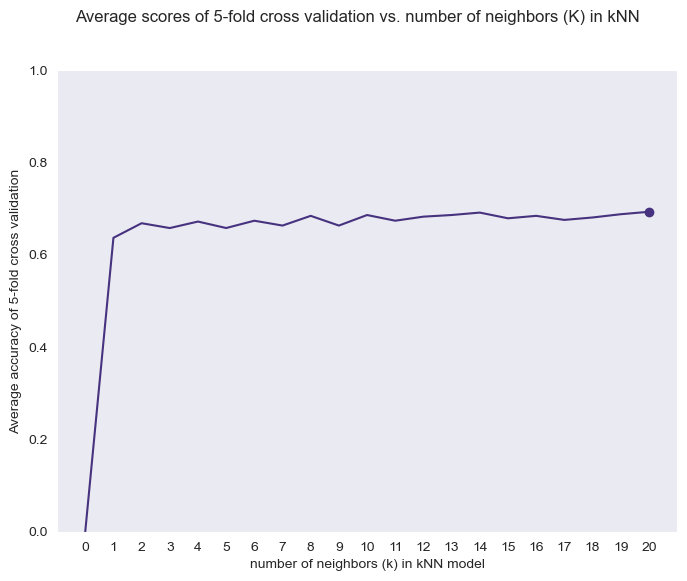

In [28]:
fig, ax = plt.subplots()
ax.plot(k_avg_score)
ax.set_xticks(np.arange(0, 21));
ax.set_ylim(0, 1)
ax.scatter(np.argmax(k_avg_score), np.max(k_avg_score))
fig.set_size_inches(8, 6)
fig.suptitle('Average scores of 5-fold cross validation vs. number of neighbors (K) in kNN')
ax.set_xlabel('number of neighbors (k) in kNN model')
ax.set_ylabel('Average accuracy of 5-fold cross validation')
plt.grid()

In [29]:
print(f"best average accuracy score is: {round(np.max(k_avg_score),3)}, for number of neighbors(k) = {np.argmax(k_avg_score)}")

best average accuracy score is: 0.693, for number of neighbors(k) = 20


In [30]:
# fit the model on the entire train set
knn = KNeighborsClassifier(n_neighbors=np.argmax(k_avg_score))
knn.fit(X_train, Y_train)

# test the model on the test set
test_score = knn.score(X_test, Y_test)
print(f"Test accuracy score is: {round(test_score,3)}")

Test accuracy score is: 0.713


In [31]:
# 4
# top 3 features correlated with the label
correlations.reindex(correlations["survived"].abs().sort_values(ascending=False).index)["survived"].iloc[:4]

survived    1.000000
sex_male   -0.536762
class       0.356462
fare        0.266100
Name: survived, dtype: float64

In [32]:
scaler = MinMaxScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

k_avg_score = np.zeros(21)
for k in range(1, 21):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    cv_scores = cross_val_score(knn_model, scaled_X_train[:, 3:6], Y_train, cv=5)  # features -- only fare, class and sex
    k_avg_score[k] = cv_scores.mean()

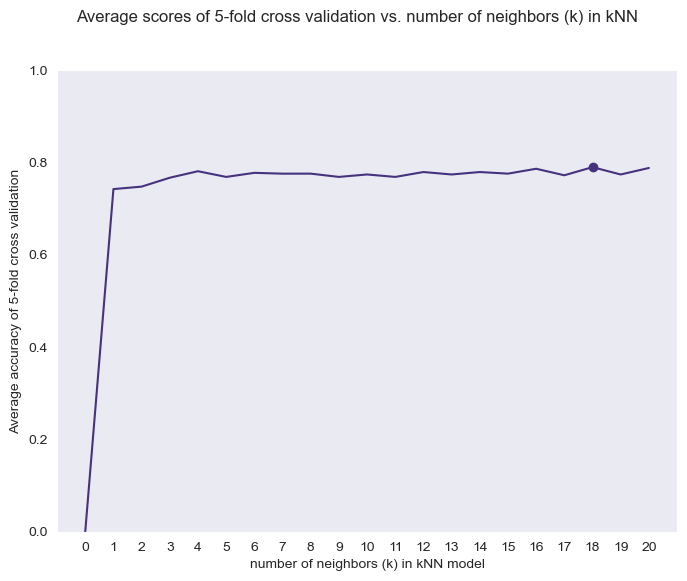

In [33]:
fig, ax = plt.subplots()
ax.plot(k_avg_score)
ax.set_xticks(np.arange(0, 21));
ax.set_ylim(0, 1)
ax.scatter(np.argmax(k_avg_score), np.max(k_avg_score))
fig.set_size_inches(8, 6)
fig.suptitle('Average scores of 5-fold cross validation vs. number of neighbors (k) in kNN')
ax.set_xlabel('number of neighbors (k) in kNN model')
ax.set_ylabel('Average accuracy of 5-fold cross validation')
plt.grid()

In [34]:
print(f"best average accuracy score is: {round(np.max(k_avg_score),3)}, for number of neighbors(k) = {np.argmax(k_avg_score)}")

best average accuracy score is: 0.789, for number of neighbors(k) = 18


In [35]:
# fit the model on the entire train set
knn = KNeighborsClassifier(n_neighbors=np.argmax(k_avg_score))
knn.fit(scaled_X_train, Y_train)

# test the model on the test set
test_score = knn.score(scaled_X_test, Y_test)
print(f"Test accuracy score is: {round(test_score,3)}")

Test accuracy score is: 0.79
